In [1]:
import os.path
import math
import re
import tensorflow as tf
import numpy as np
import facenet
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.lines as lines
%matplotlib inline

In [2]:
def get_model_filenames(model_dir):
    files = os.listdir(model_dir)
    meta_files = [s for s in files if s.endswith('.meta')]
    if len(meta_files)==0:
        raise ValueError('No meta file found in the model directory (%s)' % model_dir)
    elif len(meta_files)>1:
        raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
    meta_file = meta_files[0]
    meta_files = [s for s in files if '.ckpt' in s]
    max_step = -1
    for f in files:
        step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
        if step_str is not None and len(step_str.groups())>=2:
            step = int(step_str.groups()[1])
            if step > max_step:
                max_step = step
                ckpt_file = step_str.groups()[0]
    return meta_file, ckpt_file

def load_model(model, sess):
    model_exp = os.path.expanduser(model)
    print('Model directory: %s' % model_exp)
    meta_file, ckpt_file = get_model_filenames(model_exp)

    print('Metagraph file: %s' % meta_file)
    print('Checkpoint file: %s' % ckpt_file)

    saver = tf.train.import_meta_graph(os.path.join(model_exp, meta_file))
    saver.restore(sess, os.path.join(model_exp, ckpt_file))
    
def forward(paths, batch_size):
    nrof_images = len(paths)
    nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
    emb_array = np.zeros((nrof_images, embedding_size))

    for i in range(nrof_batches):    
        start_index = i*batch_size
        end_index = min((i+1)*batch_size, nrof_images)
        paths_batch = paths[start_index:end_index]
        images = facenet.load_data(paths_batch, False, False, image_size)
        feed_dict = { images_placeholder:images, phase_train_placeholder:False }
        emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)    
        print("batch number:", i)
    print("Complete")
    
    return emb_array

def printDistance(emb_array, label_list, end=10):
    threshold = 1.0
    lng = len(emb_array[:end])
    print('Distance matrix')
    print('    ', end='')
    for i in range(lng):
        print('    %3d     ' % i, end='')
    print('')
    for i in range(lng):
        print('%1d  ' % i, end='')
        for j in range(lng):
            dist = np.linalg.norm(emb_array[i,:] - emb_array[j,:])
            print('  %1.4f' % dist, end='')
            if (label_list[i] == label_list[j]) and (dist <= threshold):
                print("(TP)", end='')
            elif (label_list[i] != label_list[j]) and (dist > threshold):
                print("(TN)", end='')
            elif (label_list[i] == label_list[j]) and (dist > threshold):
                print("\033[93m(FN)\033[0m", end='')
            elif (label_list[i] != label_list[j]) and (dist <= threshold):
                print("\033[93m(FP)\033[0m", end='')
        print('')
        
def printData(labels, paths, number):
    for i in range(number):
        if i > 0 and labels[i] != labels[i-1]:
            print('')
        print('{0:3d} {1:3d}   {2:s}'.format(i, labels[i], paths[i].split("\\")[1]))
        # print('{0:3d}   {1:s}'.format(labels[i], paths[i].split("\\")[1]))
        
def PCAtransform(emb_array, n_components = 10):
    pca = PCA(n_components, whiten=True)
    pca.fit(emb_array)
    return pca.transform(emb_array), pca

def splitTrainTest(data_set, percent_train):
    paths, labels_list = facenet.get_image_paths_and_labels(data_set)
    
    lng = len(paths)
    lng_train = int(lng * percent_train / 100);
    lng_test = lng - lng_train
    
    train_paths = paths[0:lng_train]
    test_paths = paths[lng_train:]
    
    train_labels = labels_list[0:lng_train]
    test_labels = labels_list[lng_train:]
    
    return train_paths, train_labels, test_paths, test_labels

def trainFisher(emb_array, y):
    emb_del = np.empty_like(emb_array)
    np.copyto(emb_del, emb_array)
    
    emb_array = np.vstack((emb_array, y))
    
    # y = emb_array[sample_number]
    # emb_del = np.delete(emb_array, (sample_number), axis=0)
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w

def trainFisherWithNum(emb_array, sample_number):    
    y = emb_array[sample_number]
    emb_del = np.delete(emb_array, (sample_number), axis=0)
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w    

def Fisher(w, c, sample):
    return np.dot(w / np.linalg.norm(w), sample) - c

In [61]:
sess = tf.Session()
data_set = facenet.get_dataset("../../datasets/lfw/lfw_mtcnnpy_160/")
train_paths, train_labels, test_paths, test_labels = splitTrainTest(data_set, 100)
load_model("20170511-185253", sess)

images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

image_size = 160
embedding_size = embeddings.get_shape()[1]

Model directory: 20170511-185253
Metagraph file: model-20170511-185253.meta
Checkpoint file: model-20170511-185253.ckpt-80000
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from 20170511-185253\model-20170511-185253.ckpt-80000


In [62]:
emb_array = forward(train_paths, 100) # 100 means 100 mini-batches

batch number: 0
batch number: 1
batch number: 2
batch number: 3
batch number: 4
batch number: 5
batch number: 6
batch number: 7
batch number: 8
batch number: 9
batch number: 10
batch number: 11
batch number: 12
batch number: 13
batch number: 14
batch number: 15
batch number: 16
batch number: 17
batch number: 18
batch number: 19
batch number: 20
batch number: 21
batch number: 22
batch number: 23
batch number: 24
batch number: 25
batch number: 26
batch number: 27
batch number: 28
batch number: 29
batch number: 30
batch number: 31
batch number: 32
batch number: 33
batch number: 34
batch number: 35
batch number: 36
batch number: 37
batch number: 38
batch number: 39
batch number: 40
batch number: 41
batch number: 42
batch number: 43
batch number: 44
batch number: 45
batch number: 46
batch number: 47
batch number: 48
batch number: 49
batch number: 50
batch number: 51
batch number: 52
batch number: 53
batch number: 54
batch number: 55
batch number: 56
batch number: 57
batch number: 58
batch n

Text(0.5,1,'Standartization')

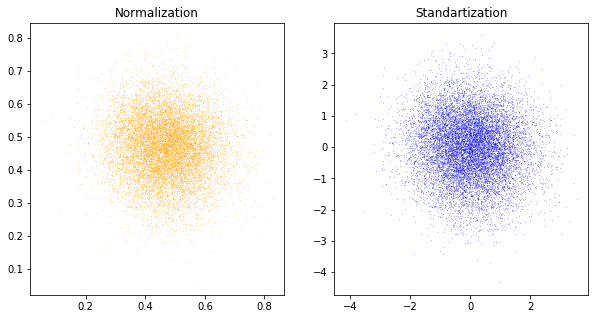

In [63]:
t = emb_array
w1 = 0
w2 = 1

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
s_ = 0.01

# Centering
tc = t - np.mean(t, axis=0)
#ax1.scatter(tc[:, 0], tc[:, 1], c="r", s=0.01)

# Normalization
tn = (tc - tc.min()) / (tc.max() - tc.min())
ax1.scatter(tn[:, w1], tn[:, w2], c="orange", s=s_)
ax1.set_title("Normalization")

# Standartization
ts = tc / tc.std(axis=0)
ax2.scatter(ts[:, w1], ts[:, w2], c="b", s=s_)
ax2.set_title("Standartization")

Text(0,0.5,'w2')

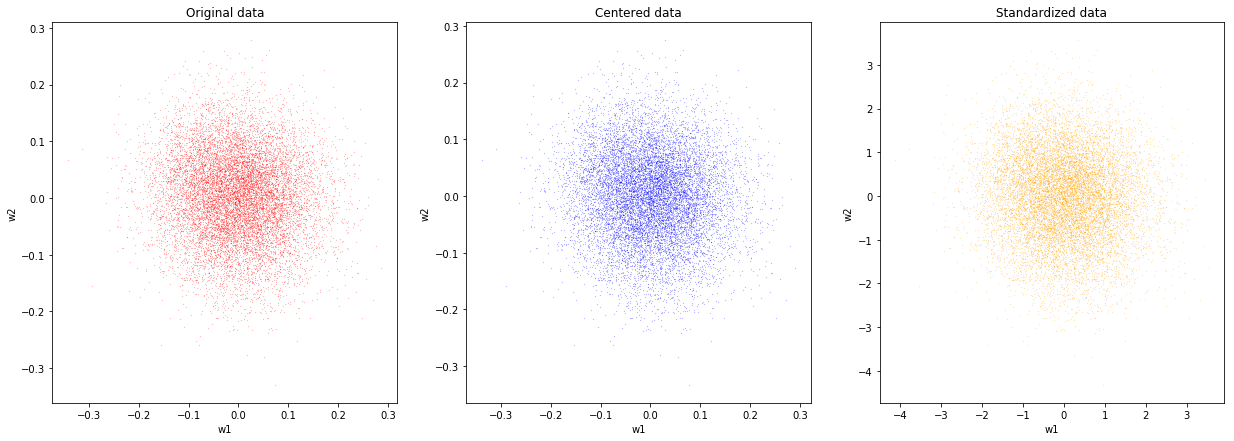

In [64]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(21,7))

# Original data
ax1.set_title("Original data")
ax1.scatter(t[:, w1], t[:, w2], c="red", s=s_)
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")

# Centered data
ax2.set_title("Centered data")
ax2.scatter(tc[:, w1], tc[:, w2], c="b", s=s_)
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")

# Standardized data
ax3.set_title("Standardized data")
ax3.scatter(ts[:, w1], ts[:, w2], c="orange", s=s_)
ax3.set_xlabel("w1")
ax3.set_ylabel("w2")

In [65]:
males = np.loadtxt("male_names.txt", dtype=str)
females = np.loadtxt("female_names.txt", dtype=str)

for i in range(len(males)):
    males[i] = males[i].replace(".jpg", ".png")
for i in range(len(females)):
    females[i] = females[i].replace(".jpg", ".png")
    
names = []
for i in range(len(train_paths)):
    names.append(train_paths[i].split("\\")[-1])
names = np.asarray(names) # from list to ndarray

indx_males = np.in1d(names, males)
indx_females = np.in1d(names, females)

Everything ok!


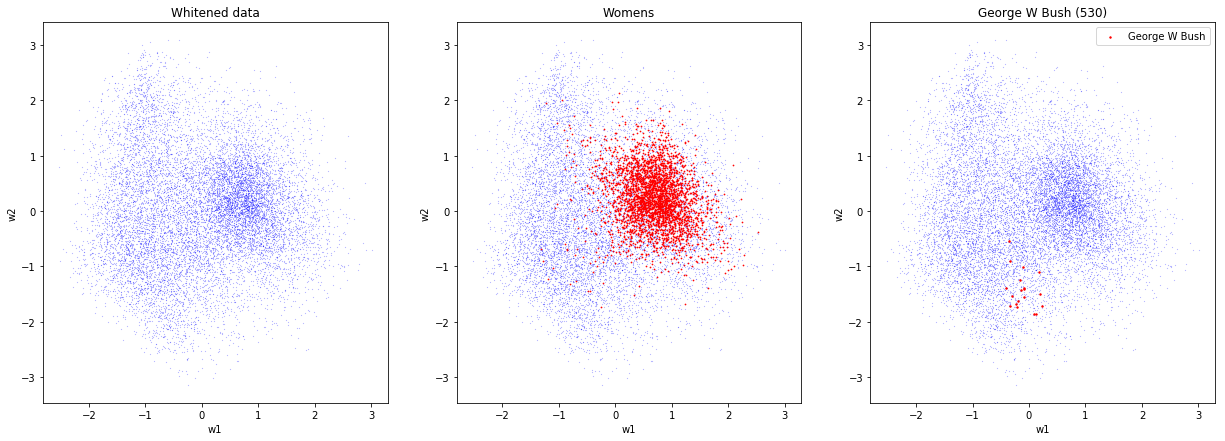

In [115]:
# Current working matrix
X = ts

cov = np.cov(X.T)
eig_vals, eig_vecs = np.linalg.eig(cov)

for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

pca_matrix = eig_pairs[0][1].reshape(128, 1)
num_components = 5

for i in range(1, num_components):
    pca_matrix = np.hstack((pca_matrix,
                            eig_pairs[i][1].reshape(128, 1)))

X_pca = X.dot(pca_matrix)

# Whitening
X_whit = X_pca / np.sqrt(eig_vals[:num_components])

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))

w1 = 0
w2 = 1

# Whitened data
ax1.set_title("Whitened data")
ax1.scatter(X_whit[:, w1], X_whit[:, w2], c="b", s=s_)
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")


X_male = X_whit[indx_males]
X_female = X_whit[indx_females]

ax2.set_title("Womens")
ax2.scatter(X_male[:, w1], X_male[:, w2], c="blue", s=s_)
ax2.scatter(X_female[:, w1], X_female[:, w2], c="red", s=0.5)
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")


train_labels = np.asarray(train_labels)
train_paths = np.asarray(train_paths)
X_left = X_whit[:, w1] > 2.5 # just for example (for finding train_labels)
Bush = X_whit[train_labels == 1871]
Powell = X_whit[train_labels == 1047]
Rumsfeld = X_whit[train_labels == 1404]

ax3.set_title("George W Bush & Colin Powell and\n Donald Rumsfeld (530, 236, 121)")
ax3.scatter(X_whit[:, w1], X_whit[:, w2], c="blue", s=s_)
ax3.scatter(Bush[:, w1], Bush[:, w2], c="red", s=2, label="George W Bush")
ax3.scatter(Powell[:, w1], Powell[:, w2], c="green", s=2, label="Colin Powell")
ax3.scatter(Rumsfeld[:, w1], Rumsfeld[:, w2], c="black", s=2, label="Donald Rumsfeld")
ax3.set_xlabel("w1")
ax3.set_ylabel("w2")
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels)



plt.savefig('Bush_and_Powell_and_Rumsfeld.png')

In [102]:
import os, os.path

DIR = '../../datasets/lfw/lfw_mtcnnpy_160/'
folder_counts = []


for name in os.listdir(DIR):
    if os.path.isdir(os.path.join(DIR, name)):
        length = len([file for file in os.listdir(os.path.join(DIR, name))])
        folder_counts.append(length)
        if (length == 121):
            print(name)

Donald_Rumsfeld


In [81]:
np.sort(folder_counts)

array([  1,   1,   1, ..., 121, 144, 236])

In [99]:
X_left = X_whit[:, w1] < -1.8

In [101]:
printData(train_labels[X_left], train_paths[X_left], 200)

  0   9   Abba_Eban_0001.png

  1 172   Alfredo_di_Stefano_0001.png

  2 249   Andre_Bucher_0001.png

  3 266   Andrew_Caldecott_0001.png

  4 270   Andrew_Gilligan_0001.png

  5 343   Anthony_Hopkins_0002.png

  6 384   Arnold_Palmer_0001.png
  7 384   Arnold_Palmer_0002.png

  8 392   Art_Howe_0001.png
  9 392   Art_Howe_0002.png

 10 450   Barry_Alvarez_0002.png

 11 469   Beecher_Ray_Kirby_0001.png

 12 539   Bill_Graham_0001.png
 13 539   Bill_Graham_0003.png
 14 539   Bill_Graham_0004.png
 15 539   Bill_Graham_0005.png
 16 539   Bill_Graham_0006.png
 17 539   Bill_Graham_0007.png
 18 539   Bill_Graham_0008.png

 19 574   Billy_Graham_0002.png

 20 576   Billy_Rork_0001.png

 21 588   Bob_Alper_0001.png

 22 606   Bob_Hope_0005.png
 23 606   Bob_Hope_0006.png
 24 606   Bob_Hope_0008.png

 25 619   Bobby_Bowden_0001.png

 26 693   Brian_Mulroney_0001.png

 27 710   Brook_Robinson_0001.png

 28 730   Bryce_Carmine_0001.png

 29 732   Bud_Selig_0004.png

 30 734   Buddy_Ryan_0001.png